In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model, create_model_bn, create_model_pruned, 
                       create_model_sequential, create_model_sequential_bn,
                       lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# from nn_globals.py

adjust_scale = 3

#learning_rate = 0.00113
#learning_rate = 0.0033
learning_rate = 0.0063

gradient_clip_norm = 100.

mask_value = 100.

discr_pt_cut = 8.

reg_pt_scale = 100.

discr_loss_weight = 20.

add_noise = True

mixture = 6

l1_reg = 0.0

l2_reg = 0.0

infile_muon = '../test7/histos_tba.20.npz'

infile_pileup = '../test7/histos_tbd.20.npz'

In [3]:
# from nn_data.py

import numpy as np

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nn_logging import getLogger
logger = getLogger()

from nn_encode import Encoder


# ______________________________________________________________________________
def muon_data(filename, adjust_scale=0, reg_pt_scale=1.0, correct_for_eta=False):
  try:
    logger.info('Loading muon data from {0} ...'.format(filename))
    loaded = np.load(filename)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
    logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
    logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
  except:
    logger.error('Failed to load data from file: {0}'.format(filename))

  assert(the_variables.shape[0] == the_parameters.shape[0])

  encoder = Encoder(the_variables, the_parameters, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale)
  if correct_for_eta:
    x, y, w, x_mask = encoder.get_x(), encoder.get_y_corrected_for_eta(), encoder.get_w(), encoder.get_x_mask()
  else:
    x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
  logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
  logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))
  assert(np.isfinite(x).all())
  return x, y, w, x_mask


def muon_data_split(filename, adjust_scale=0, reg_pt_scale=1.0, test_size=0.5, correct_for_eta=False):
  x, y, w, x_mask = muon_data(filename, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, correct_for_eta=correct_for_eta)

  # Split dataset in training and testing
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=test_size)
  logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

  # Check for cases where the number of events in the last batch could be too few
  validation_split = 0.1
  train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  return x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test


# ______________________________________________________________________________
def pileup_data(filename, adjust_scale=0, reg_pt_scale=1.0):
  try:
    logger.info('Loading pileup data from {0} ...'.format(filename))
    loaded = np.load(filename)
    the_variables = loaded['variables']
    the_parameters = np.zeros((the_variables.shape[0], 3), dtype=np.float32)
    the_aux = loaded['aux']
    logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
    logger.info('Loaded the auxiliary PU info with shape {0}'.format(the_aux.shape))
  except:
    logger.error('Failed to load data from file: {0}'.format(filename))

  assert(the_variables.shape[0] == the_aux.shape[0])
  assert(the_aux.shape[1] == 4)  # jobid, ievt, highest_part_pt, highest_track_pt

  encoder = Encoder(the_variables, the_parameters, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale)
  x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
  logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
  logger.info('Loaded the encoded auxiliary PU info with shape {0}'.format(the_aux.shape))
  assert(np.isfinite(x).all())
  return x, the_aux, w, x_mask


def pileup_data_split(filename, adjust_scale=0, reg_pt_scale=1.0, test_job=50):
  x, aux, w, x_mask = pileup_data(filename, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale)

  # Split dataset in training and testing
  split = aux[:,0].astype(np.int32) < test_job
  x_train, x_test, aux_train, aux_test, w_train, w_test, x_mask_train, x_mask_test = x[split], x[~split], aux[split], aux[~split], w[split], w[~split], x_mask[split], x_mask[~split]
  logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))
  return x_train, x_test, aux_train, aux_test, w_train, w_test, x_mask_train, x_mask_test


# ______________________________________________________________________________
def mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=14., tile=15):

  # Apply veto on PU events with a muon with pT > 14 GeV
  pu_x_train_tmp = ~(pu_aux_train[:,2] > discr_pt_cut)
  pu_x_train = pu_x_train[pu_x_train_tmp]
  pu_y_train = [pu_y_train[0][pu_x_train_tmp], pu_y_train[1][pu_x_train_tmp]]

  # Put together x_train & pu_x_train, y_train & pu_y_train
  assert(len(pu_y_train) == 2)
  assert(pu_x_train.shape[0] == pu_y_train[0].shape[0])
  assert(pu_x_train.shape[0] == pu_y_train[1].shape[0])
  num_samples = pu_x_train.shape[0]
  index_array = np.arange(num_samples)
  index_array_ext = np.tile(index_array, tile)  # choose tile to make sure pu_x_train_ext has more entries than x_train
  pu_x_train_ext = pu_x_train[index_array_ext]
  pu_y_train_ext = [pu_y_train[0][index_array_ext], pu_y_train[1][index_array_ext]]

  assert(len(y_train) == 2)
  assert(x_train.shape[0] == y_train[0].shape[0])
  assert(x_train.shape[0] == y_train[1].shape[0])
  if not (pu_x_train_ext.shape[0] >= x_train.shape[0]):
    raise Exception('pu_x_train_ext is required to have more entries than x_train. Make sure {0} >= {1}'.format(pu_x_train_ext.shape[0], x_train.shape[0]))
  num_samples = x_train.shape[0]
  index_array = np.arange(num_samples)
  #np.random.shuffle(index_array)

  try:
    from keras.engine.training import _make_batches as make_batches
  except ImportError:
    from keras.engine.training_utils import make_batches

  sample_batch_size = 128
  batches = make_batches(num_samples, sample_batch_size)

  x_train_new = np.zeros((num_samples*2, x_train.shape[1]), dtype=np.float32)
  y_train_new = [np.zeros((num_samples*2,), dtype=np.float32), np.zeros((num_samples*2,), dtype=np.float32)]

  for batch_index, (batch_start, batch_end) in enumerate(batches):
    batch_ids = index_array[batch_start:batch_end]
    x_train_new[batch_start*2:batch_start*2 + (batch_end-batch_start)] = x_train[batch_ids]
    x_train_new[batch_start*2 + (batch_end-batch_start):batch_end*2] = pu_x_train_ext[batch_ids]
    y_train_new[0][batch_start*2:batch_start*2 + (batch_end-batch_start)] = y_train[0][batch_ids]
    y_train_new[0][batch_start*2 + (batch_end-batch_start):batch_end*2] = pu_y_train_ext[0][batch_ids]
    y_train_new[1][batch_start*2:batch_start*2 + (batch_end-batch_start)] = y_train[1][batch_ids]
    y_train_new[1][batch_start*2 + (batch_end-batch_start):batch_end*2] = pu_y_train_ext[1][batch_ids]

  logger.info('Mixed muon data with pileup data. x_train_new has shape {0}, y_train_new has shape {1},{2}'.format(x_train_new.shape, y_train_new[0].shape, y_train_new[1].shape))
  return x_train_new, y_train_new

In [4]:
# from nn_encode.py

import numpy as np

nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

nvariables = (nlayers * 6) + 3 - 36

nvariables_input = (nlayers * 7) + 3

nparameters_input = 3


# ______________________________________________________________________________
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0, reg_pt_scale=1.0,
               drop_ge11=False, drop_ge21=False, drop_me0=False, drop_irpc=False):
    if x is not None and y is not None:
      assert(x.shape[1] == nvariables_input)
      assert(y.shape[1] == nparameters_input)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      # Each layer has 6 sets of features (phi, theta, bend, time, ring, fr) and 1 set of mask
      # Additionally, each road has 3 more features.
      # Some inputs are not actually used.
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_time  = self.x_copy[:, nlayers*3:nlayers*4]
      self.x_ring  = self.x_copy[:, nlayers*4:nlayers*5]
      self.x_fr    = self.x_copy[:, nlayers*5:nlayers*6]
      self.x_mask  = self.x_copy[:, nlayers*6:nlayers*7].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*7:nlayers*8]  # ipt, ieta, iphi
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]

      # Drop detectors
      x_dropit = self.x_mask
      if drop_ge11:
        x_dropit[:, 9] = 1  # 9: GE1/1
      if drop_ge21:
        x_dropit[:, 10] = 1 # 10: GE2/1
      if drop_me0:
        x_dropit[:, 11] = 1 # 11: ME0
      if drop_irpc:
        x_ring_tmp = self.x_ring.astype(np.int32)
        x_ring_tmp = (x_ring_tmp == 2) | (x_ring_tmp == 3)
        x_dropit[~x_ring_tmp[:,7], 7] = 1  # 7: RE3, neither ring2 nor ring3
        x_dropit[~x_ring_tmp[:,8], 8] = 1  # 8: RE4, neither ring2 nor ring3

      self.x_phi  [x_dropit] = np.nan
      self.x_theta[x_dropit] = np.nan
      self.x_bend [x_dropit] = np.nan
      self.x_time [x_dropit] = np.nan
      self.x_ring [x_dropit] = np.nan
      self.x_fr   [x_dropit] = np.nan
      self.x_mask [x_dropit] = 1

      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0

      # Straightness & zone
      self.x_straightness = self.x_road[:, 0][:, np.newaxis]
      self.x_zone         = self.x_road[:, 1][:, np.newaxis]

      # Subtract median phi from hit phis
      self.x_phi_median    = self.x_road[:, 2] * 32 - 5.5  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median

      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta[:,:5], axis=1)  # CSC only
      #self.x_theta_median[np.isnan(self.x_theta_median)] = np.nanmedian(self.x_theta[np.isnan(self.x_theta_median)], axis=1)  # use all types
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median

      # Standard scales
      # + Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
        x_theta_tmp = np.abs(self.x_theta) > 1.0
      elif adjust_scale == 2:  # adjust by hand
        raise NotImplementedError
      elif adjust_scale == 3:  # adjust by hand #2
        #theta_cuts    = np.array((6., 6., 6., 6., 6., 12., 12., 12., 12., 9., 9., 9.), dtype=np.float32)
        #theta_cuts    = np.array((6., 6., 6., 6., 6., 10., 10., 10., 10., 8., 8., 8.), dtype=np.float32)
        #x_theta_tmp   = np.where(np.isnan(self.x_theta), 99., self.x_theta)  # take care of nan
        #x_theta_tmp   = np.abs(x_theta_tmp) > theta_cuts
        if True:  # modify ring and F/R definitions
          x_ring_tmp = self.x_ring.astype(np.int32)
          self.x_ring[(x_ring_tmp == 2) | (x_ring_tmp == 3)] = +1 # ring 2,3 -> +1
          self.x_ring[(x_ring_tmp == 1) | (x_ring_tmp == 4)] = -1 # ring 1,4 -> -1
          x_fr_tmp = self.x_fr.astype(np.int32)
          self.x_fr[(x_fr_tmp == 1)] = +1  # front chamber -> +1
          self.x_fr[(x_fr_tmp == 0)] = -1  # rear chamber  -> -1
        if True:  # zero out some variables
          self.x_bend[:, 5:11] = 0  # no bend for RPC, GEM
          self.x_time[:, :]    = 0  # no time for everyone
          self.x_ring[:, 5:12] = 0  # ring for only ME2-4
          self.x_ring[:, 0:2]  = 0  # ^
          self.x_fr  [:, 2:11] = 0  # fr for only ME1/1, ME1/2, ME0
        s = [ 0.004297,  0.016739, -0.024291, -0.015480, -0.010096,  0.022451,
             -0.034070, -0.012700, -0.007666,  0.003452, -0.024124,  0.003120,
              0.677816,  0.696196,  1.433512,  1.540938,  1.029405,  0.226928,
              0.309345,  0.350048,  0.394817,  0.502215,  0.596152,  0.698519,
             -0.050293, -0.064527, -0.835608,  1.312986,  1.304226,  1.000000,
              1.000000,  1.000000,  1.000000, -0.542382, -0.720033, -0.074792,
              1.000000,  1.000000,  1.000000,  1.000000,  1.000000,  1.000000,
              1.000000,  1.000000,  1.000000,  1.000000,  1.000000,  1.000000,
              1.000000,  1.000000,  1.000000,  1.000000,  1.000000,  1.000000,
              1.000000,  1.000000,  1.000000,  1.000000,  1.000000,  1.000000,
              1.000000,  1.000000,  1.000000,  1.000000,  1.000000,  1.000000,
              1.000000,  1.000000,  1.000000,  1.000000,  1.000000,  1.000000,
              1.000000,  1.000000,  1.000000,  1.000000,  1.000000,  1.000000,
              1.000000,  1.000000,  1.000000,  1.000000,  1.000000,  1.000000,
              1.000000,  1.000000,  1.000000]
        self.x_copy *= s

      # Remove outlier hits by checking hit thetas
      #self.x_phi  [x_theta_tmp] = np.nan
      #self.x_theta[x_theta_tmp] = np.nan
      #self.x_bend [x_theta_tmp] = np.nan
      #self.x_time [x_theta_tmp] = np.nan
      #self.x_ring [x_theta_tmp] = np.nan
      #self.x_fr   [x_theta_tmp] = np.nan
      #self.x_mask [x_theta_tmp] = 1

      # Add variables: straightness, zone, theta_median and mode variables
      self.x_straightness = (self.x_straightness - 4.) / 4.   # scaled to [-1,1]
      self.x_zone         = (self.x_zone - 0.) / 5.           # scaled to [0,1]
      self.x_theta_median = (self.x_theta_median - 3.) / 83.  # scaled to [0,1]
      hits_to_station = np.array((5,1,2,3,4,1,2,3,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.bool)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)

      # Add dedicated GEM-CSC bend
      # Need to account for ME1/1 f or r
      #self.x_gem_csc_bend = (self.x_orig[:,9] - self.x_orig[:,0])         # 9: GE1/1, 0: ME1/1
      #self.x_gem_csc_bend[(self.x_mask[:,9] | self.x_mask[:,0])] = np.nan # 9: GE1/1, 0: ME1/1
      #self.x_gem_csc_bend = np.hstack((self.x_gem_csc_bend[:,np.newaxis], self.x_gem_csc_bend[:,np.newaxis]))
      #self.x_gem_csc_bend[(self.x_fr[:,0]!=0),0] = np.nan  # for ME1/1r bend, set ME1/1f to nan
      #self.x_gem_csc_bend[(self.x_fr[:,0]!=1),1] = np.nan  # for ME1/1f bend, set ME1/1r to nan
      #if adjust_scale == 3:
      #  self.x_gem_csc_bend *= [0.012216, 0.027306]

      # Remove NaN
      self._handle_nan_in_x(self.x_copy)
      #self._handle_nan_in_x(self.x_gem_csc_bend)

      # Scale q/pT for training
      self.y_pt *= reg_pt_scale
      return

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def _handle_nan_in_x(self, x):
    x[np.isnan(x)] = 0.0
    return x

  def get_x(self, drop_columns_of_zeroes=True):
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend,
                       self.x_time, self.x_ring, self.x_fr,
                       self.x_straightness, self.x_zone, self.x_theta_median))
    # Drop input nodes
    if drop_columns_of_zeroes:
      drop_phi    = [nlayers*0 + x for x in xrange(0,0)]  # keep everyone
      drop_theta  = [nlayers*1 + x for x in xrange(0,0)]  # keep everyone
      drop_bend   = [nlayers*2 + x for x in xrange(5,11)] # no bend for RPC, GEM
      drop_time   = [nlayers*3 + x for x in xrange(0,12)] # no time for everyone
      drop_ring   = [nlayers*4 + x for x in xrange(5,12)] # ring for only ME2, ME3, ME4
      drop_ring  += [nlayers*4 + x for x in xrange(0,2)]  # ^
      drop_fr     = [nlayers*5 + x for x in xrange(2,11)] # fr for only ME1/1, ME1/2, ME0

      x_dropit = np.zeros(x_new.shape[1], dtype=np.bool)
      for i in drop_phi + drop_theta + drop_bend + drop_time + drop_ring + drop_fr:
        x_dropit[i] = True

      #x_dropit_test = np.all(x_new == 0, axis=0)  # find columns of zeroes
      #assert(list(x_dropit) == list(x_dropit_test))

      x_new = x_new[:, ~x_dropit]
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_y_corrected_for_eta(self):
    y_new = self.y_pt * (np.sinh(1.8587) / np.sinh(np.abs(self.y_eta)))
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']

### Import data

In [5]:
# Import muon data
# 'x' is the input variables with shape (n, 87), 'y' is the q/pT with shape (n, 1)
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.31)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.20.npz ...
[INFO    ] Loaded the variables with shape (3272341, 87)
[INFO    ] Loaded the parameters with shape (3272341, 3)
[INFO    ] Loaded the encoded variables with shape (3272341, 39)
[INFO    ] Loaded the encoded parameters with shape (3272341,)
[INFO    ] Loaded # of training and testing events: (2257915, 1014426)


In [6]:
# Import pileup data
# 'x' is the input variables with shape (n, 87), 'aux' is pileup info with shape (n, 4)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_job=131)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from ../test7/histos_tbd.20.npz ...
[INFO    ] Loaded the variables with shape (816244, 87)
[INFO    ] Loaded the auxiliary PU info with shape (816244, 4)
[INFO    ] Loaded the encoded variables with shape (816244, 39)
[INFO    ] Loaded the encoded auxiliary PU info with shape (816244, 4)
[INFO    ] Loaded # of training and testing events: (652320, 163924)


In [7]:
# Mix muon & pileup data
x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut, tile=5)

[INFO    ] Mixed muon data with pileup data. x_train_new has shape (4515830, 39), y_train_new has shape (4515830,),(4515830,)


### Make plots

In [8]:
# Styling
plt.style.use('tdrstyle.mplstyle')

0 (643906,) (2257915,) (4515830,)
1 (643906,) (2257915,) (4515830,)
2 (643906,) (2257915,) (4515830,)
3 (643906,) (2257915,) (4515830,)
4 (643906,) (2257915,) (4515830,)
5 (643906,) (2257915,) (4515830,)
6 (643906,) (2257915,) (4515830,)
7 (643906,) (2257915,) (4515830,)
8 (643906,) (2257915,) (4515830,)
9 (643906,) (2257915,) (4515830,)
10 (643906,) (2257915,) (4515830,)
11 (643906,) (2257915,) (4515830,)
12 (643906,) (2257915,) (4515830,)
13 (643906,) (2257915,) (4515830,)
14 (643906,) (2257915,) (4515830,)
15 (643906,) (2257915,) (4515830,)
16 (643906,) (2257915,) (4515830,)
17 (643906,) (2257915,) (4515830,)
18 (643906,) (2257915,) (4515830,)
19 (643906,) (2257915,) (4515830,)
20 (643906,) (2257915,) (4515830,)
21 (643906,) (2257915,) (4515830,)
22 (643906,) (2257915,) (4515830,)
23 (643906,) (2257915,) (4515830,)
24 (643906,) (2257915,) (4515830,)
25 (643906,) (2257915,) (4515830,)
26 (643906,) (2257915,) (4515830,)
27 (643906,) (2257915,) (4515830,)
28 (643906,) (2257915,) (45158

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


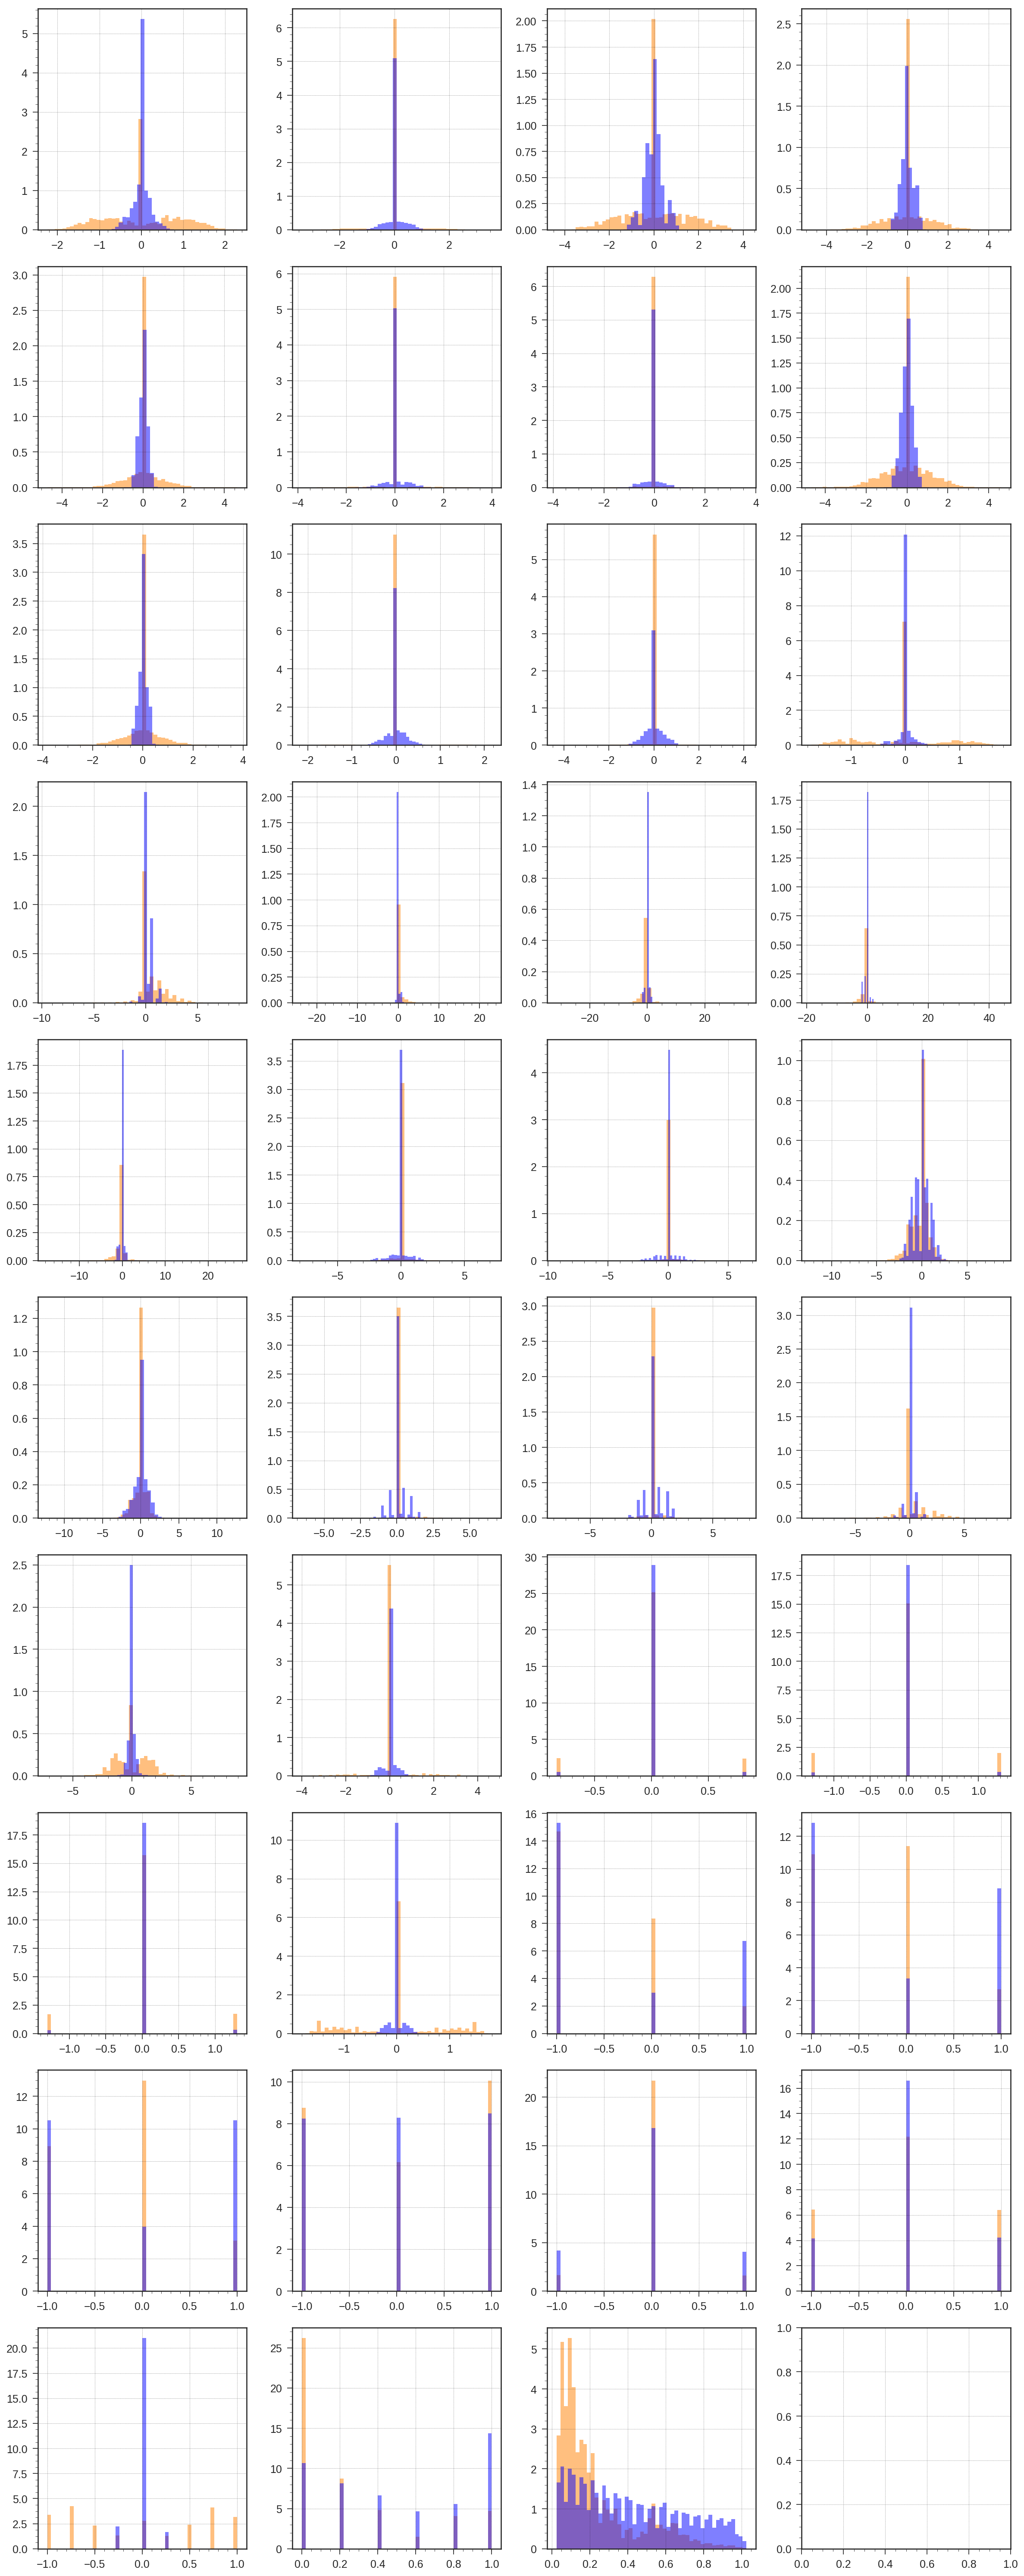

In [9]:
fig, axs = plt.subplots(40/4, 4, figsize=(4*4,4*40/4), tight_layout=True)

_kwargs = dict(histtype='stepfilled', linewidth=2, alpha=0.5, density=True, bins=50)

for i in xrange(x_train.shape[1]):
  x_sig = x_train_new[:, i].copy()
  x_bkg = x_train_new[:, i].copy()
  y_discr = y_train_new[1].copy()
  
  #print i, x_sig.shape, x_bkg.shape, y_discr.shape
  
  x_sig = x_sig[y_discr == 1]
  x_bkg = x_bkg[y_discr == 0]
  
  print i, x_sig.shape, x_bkg.shape, y_discr.shape
  
  # Background in orange
  hist = axs[(i/4, i%4)].hist(x_bkg, color='#FF8000', **_kwargs)
  
  # Signal in blue
  hist = axs[(i/4, i%4)].hist(x_sig, color='blue', **_kwargs)
  
  ##FIXME
  #hist = axs[(i/4, i%4)].hist(x_bkg[x_bkg != 0], color='#FF8000', **_kwargs)

0 (430617,) (490763,) (2257915,) (652320,)
1 (211194,) (86597,) (2257915,) (652320,)
2 (567743,) (435313,) (2257915,) (652320,)
3 (558028,) (355920,) (2257915,) (652320,)
4 (542013,) (315356,) (2257915,) (652320,)
5 (154801,) (51570,) (2257915,) (652320,)
6 (149093,) (41355,) (2257915,) (652320,)
7 (546363,) (420854,) (2257915,) (652320,)
8 (511709,) (318520,) (2257915,) (652320,)
9 (297239,) (34327,) (2257915,) (652320,)
10 (356772,) (61343,) (2257915,) (652320,)
11 (216084,) (333701,) (2257915,) (652320,)
12 (430617,) (490763,) (2257915,) (652320,)
13 (211194,) (86597,) (2257915,) (652320,)
14 (567743,) (435313,) (2257915,) (652320,)
15 (558028,) (355920,) (2257915,) (652320,)
16 (542013,) (315356,) (2257915,) (652320,)
17 (154801,) (51570,) (2257915,) (652320,)
18 (149093,) (41355,) (2257915,) (652320,)
19 (546363,) (420854,) (2257915,) (652320,)
20 (511709,) (318520,) (2257915,) (652320,)
21 (297239,) (34327,) (2257915,) (652320,)
22 (356772,) (61343,) (2257915,) (652320,)
23 (2160

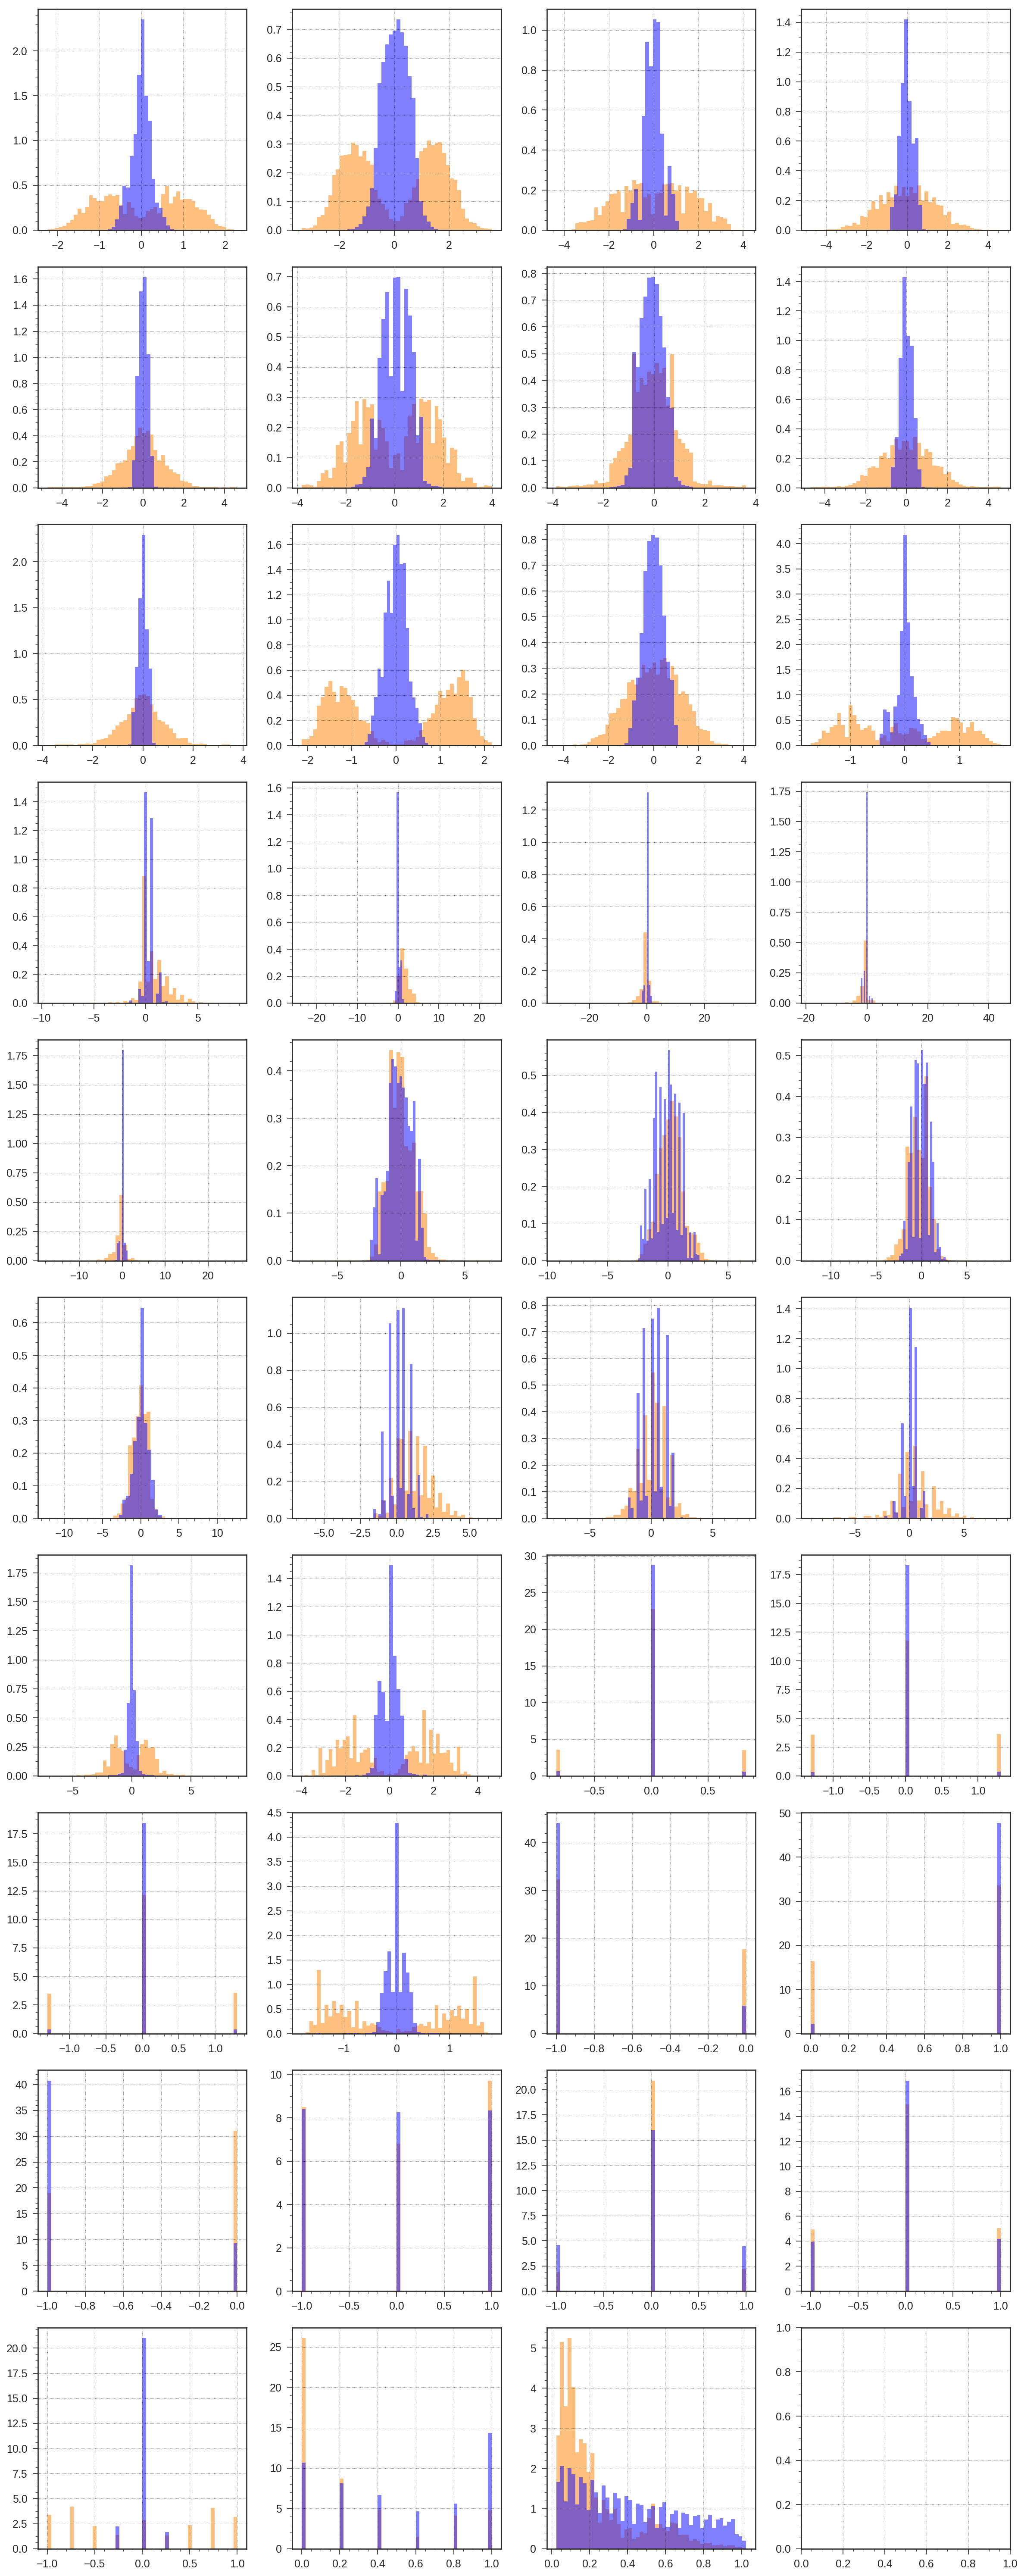

In [10]:
fig, axs = plt.subplots(40/4, 4, figsize=(4*4,4*40/4), tight_layout=True)

_kwargs = dict(histtype='stepfilled', alpha=0.5, linewidth=2, density=True, bins=50)

def parse_x_mask(x_mask):
  nentries = x_mask.shape[0]
  x_mask_new = np.ones((nentries, nvariables), dtype=np.bool)
  x_mask_new[:, 0:12]  = np.hstack((x_mask,))
  x_mask_new[:, 12:24] = np.hstack((x_mask,))
  x_mask_new[:, 24:30] = np.hstack((x_mask[:,0:5], x_mask[:,11:12]))
  x_mask_new[:, 30:33] = np.hstack((x_mask[:,0:2], x_mask[:,11:12]))
  x_mask_new[:, 33:36] = np.hstack((x_mask[:,2:5],))
  x_mask_new[:, 36:39] = 0
  return x_mask_new

x_mask_train_new = parse_x_mask(x_mask_train)
pu_x_mask_train_new = parse_x_mask(pu_x_mask_train)

for i in xrange(x_train.shape[1]):
  x_sig = x_train[:, i].copy()
  x_bkg = pu_x_train[:, i].copy()
  y_sig = y_train[1].copy()
  y_bkg = pu_y_train[1].copy()
  x_mask_sig = x_mask_train_new[:, i].copy()
  x_mask_bkg = pu_x_mask_train_new[:, i].copy()
  
  #print i, x_sig.shape, x_bkg.shape, x_mask_sig.shape, x_mask_bkg.shape
  
  x_sig = x_sig[(~x_mask_sig) & (y_sig == 1)]
  x_bkg = x_bkg[(~x_mask_bkg) & (y_bkg == 0)]
  
  print i, x_sig.shape, x_bkg.shape, x_mask_sig.shape, x_mask_bkg.shape
  
  # Background in orange
  hist = axs[(i/4, i%4)].hist(x_bkg, color='#FF8000', **_kwargs)
  
  # Signal in blue
  hist = axs[(i/4, i%4)].hist(x_sig, color='blue', **_kwargs)